# Overlap in Lexical and Literary Vocabulary

Comparing the vocabulary of Old Babylonian lexical texts (from Nippur) and the vocabulary of the Sumerian literary corpus as represented in [ETCSL](http://etcsl.orinst.ox.ac.uk/).

## Preparation 
In order to run this notebook, parse the [DCCLT](http://oracc.org/dcclt) data with the Extended ORACC Parser (2.3.3) and the [ETCSL](http://etcsl.orinst.ox.ac.uk) data with the ETCSL Parser (2.4).

In [1]:
%matplotlib inline
import pandas as pd
import os
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
import tqdm
import re

# Read ETCSL Data Files
Open the file `parsed.csv`which contains all the [ETCSL](http://etcsl.orinst.ox.ac.uk) and read the data into a `Pandas`DataFrame. Each row is a word from [ETCSL](http://etcsl.orinst.ox.ac.uk/) in lemmatized format, according to [ePSD2](http://build-oracc.museum.upenn.edu/epsd2) standards.

In [2]:
file = "../2_4_Data_Acquisition_ETCSL/Output/alltexts.csv"
etcsl = pd.read_csv(file, keep_default_na=False)
etcsl = etcsl.loc[etcsl["lang"].str.contains("sux")]  # throw out non-Sumerian words

## Lemmas
Create a lemmas column and lowercase all lemmas.

In [3]:
etcsl["lemma"] = etcsl.apply(lambda r: (r["cf"] + '[' + r["gw"] + ']' + r["pos"]) 
                            if r["cf"] != '' else r['form'] + '[NA]NA', axis=1)
etcsl['lemma'] = [lemma if not lemma == '[NA]NA' else '' for lemma in etcsl['lemma'] ] 
# kick out empty forms
etcsl["lemma"] = etcsl["lemma"].str.lower()

In [4]:
etcsl = etcsl[etcsl["lemma"]!=""]  # remove lines that have no content

# Read Lexical Data

Essentially following the same process as in the preceding cell.

In [5]:
file = "../2_3_Data_Acquisition_ORACC/output/parsed.csv"
lexical = pd.read_csv(file, keep_default_na=False)
lexical

,base,cf,cont,delim,epos,extent,form,gdl,gw,id_text,...,label,lang,morph,norm,norm0,pos,scope,sense,state,id_line
0,,,,,,,kuš,"[{'v': 'kuš', 'hc': '1', 'ho': '1', 'id': 'P23...",,dcclt/P231172,...,o ii 1,sux,,,,,,,,4
1,,,,,,,x,"[{'breakStart': '1', 'o': ']', 'id': 'P231172....",,dcclt/P231172,...,o ii 1,sux,,,,,,,,4
2,,,,,,,kuš,"[{'v': 'kuš', 'id': 'P231172.5.1.0'}]",,dcclt/P231172,...,o ii 2,sux,,,,,,,,5
3,,,,,,,x,"[{'breakStart': '1', 'o': ']', 'id': 'P231172....",,dcclt/P231172,...,o ii 2,sux,,,,,,,,5
4,,,,,,,kuš,"[{'v': 'kuš', 'id': 'P231172.6.1.0'}]",,dcclt/P231172,...,o ii 3,sux,,,,,,,,6
5,,,,,,,x,"[{'breakStart': '1', 'o': ']', 'id': 'P231172....",,dcclt/P231172,...,o ii 3,sux,,,,,,,,6
6,,,,,,,kuš,"[{'v': 'kuš', 'id': 'P231172.7.1.0'}]",,dcclt/P231172,...,o ii 4,sux,,,,,,,,7
7,,,,,,,x,"[{'breakStart': '1', 'o': ']', 'id': 'P231172....",,dcclt/P231172,...,o ii 4,sux,,,,,,,,7
8,,,,,,,kuš,"[{'v': 'kuš', 'id': 'P231172.8.1.0'}]",,dcclt/P231172,...,o ii 5,sux,,,,,,,,8
9,,,,,,,x,"[{'breakStart': '1', 'o': ']', 'id': 'P231172....",,dcclt/P231172,...,o ii 5,sux,,,,,,,,8


In [6]:
lexical["lemma"] = lexical.apply(lambda r: (r["cf"] + '[' + r["gw"] + ']' + r["pos"]) 
                            if r["cf"] != '' else r['form'] + '[NA]NA', axis=1)
lexical['lemma'] = [lemma if not lemma == '[NA]NA' else '' for lemma in lexical['lemma'] ] 
# kick out empty forms
lexical["lemma"] = lexical["lemma"].str.lower()

# Select Lexical Compositions
Select the following compositions: 
* Ura 1 dcclt/Q000039
* Ura 2 dcclt/Q000040
* Ura 3 dcclt/Q000001
* Ura 4 dcclt/Q000041
* Ura 5 dcclt/Q000042
* Ura 6 dcclt/Q000043
* Lu₂-Azlag₂ B/C Q000302 
* Ugumu dcclt/Q00268
* Diri dcclt/Q000057
* Nigga dcclt/Q000052
* Izi dcclt/Q000050
* Kagal dcclt/Q000048
* Lu dcclt/Q000047

Lowercase all lemmas.

In [7]:
keep = ["dcclt/Q000039", 
    "dcclt/Q000040",
    "dcclt/Q000001",
    "dcclt/Q000041",
    "dcclt/Q000042",
    "dcclt/Q000043",
    "dcclt/Q000302 ",
    "dcclt/Q00268",
    "dcclt/Q000057",
    "dcclt/Q000052",
    "dcclt/Q000050",
    "dcclt/Q000048",
    "dcclt/Q000047"]
lexical = lexical.loc[lexical["id_text"].isin(keep)]

In [8]:
lexical = lexical[lexical["lemma"]!=""] # remove lines without content.

# First Approximation
Extract the vocabulary of ETCSL and the lexical texts. Count each word separately. Thus, in the lexical item `gud an-na` we count the words `gud` (ox) and `an` (heaven) separately to see if those words appear in the literary corpus as well. This approach, therefore, does not take account of attestations of `gud an-na` in both corpora.

In [9]:
etcsl_words = ' '.join(list(etcsl["lemma"]))
lexical_words = ' '.join(list(lexical["lemma"]))
etcsl_words_l = etcsl_words.split()
lexical_words_l = lexical_words.split()
etcsl_words_l = [word for word in etcsl_words_l if not "[na]na" in word] # kick out unlemmatized words
lexical_words_l = [word for word in lexical_words_l if not "[na]na" in word]
etcsl_words_s = set(etcsl_words_l)
lexical_words_s = set(lexical_words_l)

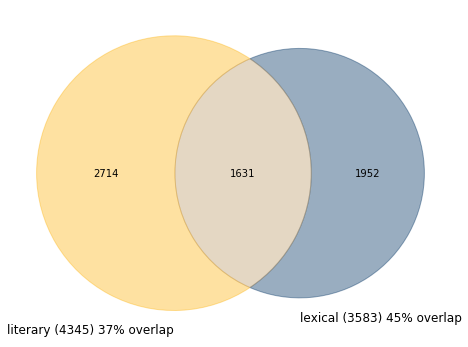

In [10]:
plt.figure(figsize=(8,8))
lit_abs = len(etcsl_words_s)
lex_abs = len(lexical_words_s)
inter_abs = len(etcsl_words_s.intersection(lexical_words_s))
lit_per = int(inter_abs/lit_abs * 100)
lex_per = int(inter_abs/lex_abs * 100)
lit_legend = "literary (" + str(lit_abs) + ') ' + str(lit_per) + "% overlap"
lex_legend = "lexical (" + str(lex_abs) + ') ' + str(lex_per) + "% overlap"
c = venn2([etcsl_words_s, lexical_words_s], (lit_legend, lex_legend))
c.get_patch_by_id('10').set_color("#fdb515")
c.get_patch_by_id('01').set_color("#003262")
c.get_patch_by_id('11').set_color("#bc9b6a")
plt.show()

# Mark Multiple Word Expressions

Instead of looking at individual words (or lexemes), we may also look at lexical *entries* and their appearance (or not) in literary texts. The list of domestic animals, for instance, includes the entry `udu dijir-e gu₇-a`('sheep eaten by a god'), lemmatized as `udu[sheep]n diŋir[god]n gu[eat]v/t`. Unsurprisingly, all these lemmas appear in the literary corpus, and thus in our previous analysis this item results in three hits. But does the expression as a whole ever appear in the literary corpus? 

In order to perform the comparison on the lexical entry level we first need to represent our data (lexical and literary) as lines (rather than individual words).


## Line by Line
In order to reconstruct lines we the Pandas function `groupby()` with the fields `id_text` and `id_line`. The `agg()` function indicates which fields (beside `id_text` and `id_line`) are kept and how they are treated (see also 2.3.???).

In [11]:
lexical = lexical.groupby([lexical['id_text'], lexical['id_line']]).agg({
        'lemma': ' '.join,
        'extent': ''.join
    }).reset_index()

In [12]:
etcsl = etcsl.groupby([etcsl['id_text'], etcsl['id_line'], etcsl['text_name']]).agg({
        'lemma': ' '.join,
        'extent': ''.join
    }).reset_index()

## Extract lexical entries 
Each item in the resulting list now consists of the lemmas of an entire lexical *entry* (e.g. `udu[sheep]n diŋir[god]n gu[eat]v/t`). Replace all spaces by asterisks, so that the whole string can be treated as a unity.

In [13]:
lex_vocab = list(set(lexical["lemma"]))
lex_vocab = [item.replace(" ", "*") for item in lex_vocab]

## Mark lexical entries in literary texts
Iterate through the list of lexical vocabulary (beginning with the longest items) and check to see if the item contains multiple lemmatizations (contains asterisks). If so, the `str.replace()` function of Pandas is used to find identical sequences of lemmas in a line in the `etcsl` DataFrame and to equally replace spaces by asterisks.

In order to do so we create a `findwhat` variable that is derived from the lexical item. First the asterisks are  replaced again by spaces (we are looking for, say, `udu[sheep]n diŋir[god]n gu[eat]v/t`). Second, all square brackets need to be escaped. The `str.replace()` function will interpret these square brackets as special characters in a [regular expression](https://www.regular-expressions.info/), not as literals, unless we escape them with a backslash. 

It is possible to add the argument `regex = False`,  but then `str.replace()` will only be looking for a match between full strings, not substrings - e.g. `udu[sheep]n diŋir[god]n gu[eat]v/t` will be matched by `udu[sheep]n diŋir[god]n gu[eat]v/t`, but not by the substring of  `sila[lamb]n udu[sheep]n diŋir[god]n gu[eat]v/t`.

The `lemma` column of the `etcsl` dataframe will now represent the [ETCSL](http://etcsl.orinst.ox.ac.uk/) data in a line-by-line presentation of the lemmatizations, with asterisks connecting lemmas if a corresponding sequence of lemmas exists as a lexical entry.

# TODO
The following cell will not run because of the Diri data. These data include the sign descriptions, such as |SI.A| which results in large number of "or" expressions in regex (now provisionally solved with `re.escape()`). The solution is to throw out all such items from the data set. Similarly, sign readings should be thrown out. 

Before the comparison is run all lexical entries with [na]na component should be removed.

In [14]:
lex_vocab.sort(key=len, reverse=True)
for item in tqdm.tqdm(lex_vocab):
    if "*" in item:
        findwhat = item.replace("*", " ")
        findwhat = re.escape(findwhat)
        etcsl["lemma"] = etcsl["lemma"].str.replace(findwhat, item)

100%|██████████████████████████████████████| 6367/6367 [11:38<00:00,  9.12it/s]


In [15]:
etcsl[etcsl["lemma"].str.contains("*", regex=False)]

,id_text,id_line,text_name,extent,lemma
10,c.0.1.1,11,Ur III catalogue from Nibru (N1),,x[na]na*x[na]na kaskal[way]n 7[7]nu me[be]v/i
12,c.0.1.1,13,Ur III catalogue from Nibru (N1),,igi[eye]n*x[na]na 7[7]nu kur[enter]v/i
13,c.0.1.1,14,Ur III catalogue from Nibru (N1),,šul[youth]v/i a[arm]n*la[hang]v/t
27,c.0.1.2,7,Ur III catalogue at Yale (Y1),,munus[woman]n zid[right]v/i mi[cvne]n*dug[spea...
38,c.0.1.2,18,Ur III catalogue at Yale (Y1),,lugal[king]n inim[word]n*sag[good]v/i
45,c.0.1.2,25,Ur III catalogue at Yale (Y1),,lugal[king]n ŋeštug[ear]n*daŋal[wide]v/i
67,c.0.2.01,2,OB catalogue from Nibru (N2),,lugal[king]n mi[cvne]n*dug[speak]v/t
75,c.0.2.01,10,OB catalogue from Nibru (N2),,en[lord]n kur[mountain]n lu[person]n*til[live]v/i
81,c.0.2.01,16,OB catalogue from Nibru (N2),,kud[fish]n e[house]n*du[build]v/t
95,c.0.2.01,30,OB catalogue from Nibru (N2),,gi[thicket]n ana[what?]qp gu[voice]n*de[pour]v/t


In [16]:
etcsl_words2 = ' '.join(list(etcsl["lemma"]))
etcsl_words_s2 = set(etcsl_words2.split())
lexical_words_s2 = set(lex_vocab)

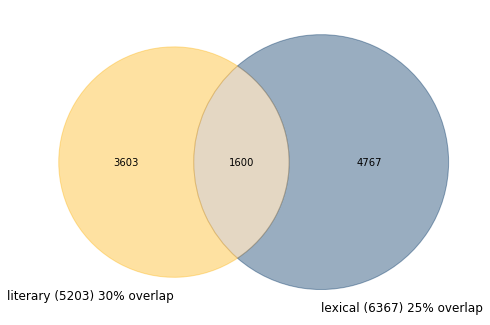

In [18]:
plt.figure(figsize=(8,8))
lit_abs = len(etcsl_words_s2)
lex_abs = len(lexical_words_s2)
inter_abs = len(etcsl_words_s2.intersection(lexical_words_s2))
lit_per = int(inter_abs/lit_abs * 100)
lex_per = int(inter_abs/lex_abs * 100)
lit_legend = "literary (" + str(lit_abs) + ') ' + str(lit_per) + "% overlap"
lex_legend = "lexical (" + str(lex_abs) + ') ' + str(lex_per) + "% overlap"
c = venn2([etcsl_words_s2, lexical_words_s2], (lit_legend, lex_legend))
c.get_patch_by_id('10').set_color("#fdb515")
c.get_patch_by_id('01').set_color("#003262")
c.get_patch_by_id('11').set_color("#bc9b6a")
plt.show()

# Add them Up
By creating the union of the two sets (the set with individual words and the set with the lexical entries only) we get the most complete comparison of the two corpora. Here `gud[oxen]N*an[heaven]N`, `gud[oxen]N` and `an[heaven]N` are all counted as words, whether or not `gud` and `an` actually appear as such in the lexical corpus.

In [19]:
etcsl_words_s3 = etcsl_words_s | etcsl_words_s2
lexical_words_s3 = lexical_words_s | lexical_words_s2

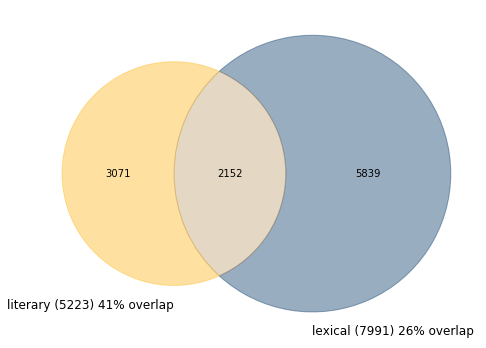

In [20]:
#plt.figure(figsize=(8,8))
#lit_legend = "literary (" + str(len(etcsl_words_s3)) + ')'
#lex_legend = "lexical (" + str(len(lexical_words_s3)) + ")"
#venn2([etcsl_words_s3, lexical_words_s3], (lit_legend, lex_legend))
#plt.show()

plt.figure(figsize=(8,8))
lit_abs = len(etcsl_words_s3)
lex_abs = len(lexical_words_s3)
inter_abs = len(etcsl_words_s3.intersection(lexical_words_s3))
lit_per = int(inter_abs/lit_abs * 100)
lex_per = int(inter_abs/lex_abs * 100)
lit_legend = "literary (" + str(lit_abs) + ') ' + str(lit_per) + "% overlap"
lex_legend = "lexical (" + str(lex_abs) + ') ' + str(lex_per) + "% overlap"
c = venn2([etcsl_words_s3, lexical_words_s3], (lit_legend, lex_legend))
c.get_patch_by_id('10').set_color("#fdb515")
c.get_patch_by_id('01').set_color("#003262")
c.get_patch_by_id('11').set_color("#bc9b6a")
plt.show()

In [21]:
len(etcsl_words_s), len(etcsl_words_s2), len(etcsl_words_s3)

(4345, 5203, 5223)

# Create a Corpus
The etcsl dataframe is organized by line. The `aggregate` function assembles the lines that belong to a single composition. The resulting dataframe has 394 entries, one for each composition. 

In [ ]:
corpus = etcsl.groupby([etcsl["etcsl_no"], etcsl["text_name"]]).aggregate({"text": " ".join}).reset_index()

# Document Term Matrix
The corpus is transformed into a Document Term Matrix (or DTM) in which each word (or expression) is a column and each row a Sumerian composition. The lexical vocabulary is used as a filter (only words that appear in the lexical texts are allowed in the DTM).

First sort the lexical vocabulary alphabetically.

Use CountVectorizer (from Sklearn) to initiate the DTM. The `token_pattern` indicates what a word looks like and what signals the end of a word. In modern corpora this can be fairly complex (including spaces, commas, full stops, etc.) but in the current corpus a space will always separate one token from the next. The regex `r'[^ ]+'` means "any sequence of characters, except space".

Transform the DTM to a dataframe.

NB a DTM is not necessary for the raw comparison/Venn diagram - only for further inspection.

In [ ]:
cv = CountVectorizer(analyzer='word', token_pattern=r'[^ ]+', binary = False, vocabulary=lex_vocab)
etcsl_dtm = cv.fit_transform(corpus['text'])
#etcsl_df = pd.DataFrame(etcsl_dtm.toarray(), columns= cv.get_feature_names(), index=corpus["etcsl_no"])
etcsl_df = pd.DataFrame(etcsl_dtm.toarray(), columns= lex_vocab, index=corpus["etcsl_no"])

In [ ]:
etcsl_df

# Words in Lexical Texts not in ETCSL
If a word or expression in the lexical corpus is never used in the literary texts from [ETCSL](http://etcsl.orinst.ox.ac.uk/) the sum of its column will be `0`.

Give the number of columns (the number of unique words and expressions in the lexical texts), the number of words/expressions never used in the ETCSL corpus and the relation between those two numbers in percent.

In [ ]:
lex_not_in_etcsl = etcsl_df.loc[:, etcsl_df.sum()==0]
len(etcsl_df.columns), len(lex_not_in_etcsl.columns), str(len(lex_not_in_etcsl.columns)/len(etcsl_df.columns)*100) + "%"

# Simplify
The above may be an overly complex way of doing it.
Alternative: make a full dtm of etcsl (without a vocabulary constraint); make the etcsl vocabulary and lexical vocabulary into sets that can be subtracted from each other.

In [ ]:
cv = CountVectorizer(analyzer='word', token_pattern=r'[^ ]+', binary = False)
etcsl2_dtm = cv.fit_transform(corpus['text'])
etcsl2_df = pd.DataFrame(etcsl2_dtm.toarray(), columns= cv.get_feature_names(), index=corpus["etcsl_no"])
etcsl_vocab_s = set(etcsl2_df.columns)
lex_vocab_s = set(lex_vocab)
diff_e_l = list(etcsl_vocab_s - lex_vocab_s)
diff_l_e = list(lex_vocab_s - etcsl_vocab_s)

In [ ]:
print("number of words/expressions in ETCSL " + str(len(etcsl_vocab_s)))
print("number of words/expressions in lexical texts " + str(len(lex_vocab_s)))
print("number of words/expressions in ETCSL not in lexical " + str(len(diff_e_l)))
print("number of words/expressions in lexical not in ETCSL " + str(len(diff_l_e)))

In [ ]:
plt.figure(figsize=(4,4))
venn2([etcsl_vocab_s, lex_vocab_s], ("literary", "lexical"))
plt.show()

# Rare Words Shared by Lex and Lit
Which words appear in Lex and in Lit but appear only once in Lit? In which composition do we find such words; which words are those?

First create a dataframe (`rare`) that only has the columns that add up to `1` (word or expression appears only once in the corpus). The row totals of this dataframe indicate per composition (= row) how many such rare words they contain. These row totals are added as a separate column. The composition naes are extracted from the `corpus` dataframe created above. Finally the dataframe is sorted by the row totals.

The dataframe `rare` includes columns for each of the words that appear only once. We are showing only the columns that identify the composition and the row totals.

In [ ]:
rare =etcsl_df.loc[:, etcsl_df.sum()==1].reset_index()
rare["no. of unique lexical correspondences"] = rare.sum(axis=1)
rare["text_name"] = corpus["text_name"]
rare = rare.sort_values('no. of unique lexical correspondences', ascending = False)
rare.loc[:,["etcsl_no", "no. of unique lexical correspondences", "text_name"]]

# Which Words?
Which are the rare words that define this list of compositions? We first extract the full list of words from the column names of the daraframe `rare`. The variable `words` is a Numpy array that contains strings.

In [ ]:
words = rare.columns.values
len(words)

# The rare words in the top-ten
The first ten compositions in our list are the ones that have the most rare words shared with lexical texts. Each row, representing a composition, has columns that represent individual words. We create a `mask` (a sequence of boolean values `True` or `False`) that indicate whether or not the value in the column is 1. If the boolean is `True` the word is printed.

In [ ]:
for i in range(10):
    indexes = rare.iloc[i] == 1
    print(rare.iloc[i,-1]), print(words[indexes])

In [ ]:
lexical["text"] = lexical["text"].str.replace(" ", "*")
lexical

In [ ]:
lexical_corpus = lexical.groupby([lexical["id_text"], 
                                  lexical["text_name"]]).aggregate({"text": " ".join}).reset_index()
lexical_corpus